### Recognizing High-redshift Galaxy Mergers with Convolutional Neural Networks using DeepMerge simulated data with an application on real-world data
# Simulated data

In [1]:
import os
import numpy as np
import time

from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd

In [46]:
import sys
sys.path.insert(0,'../src/')
import sim_data


['../src/', '../src/', '../src/', '../src/', '../src/', '../src/', '../src/', '/Users/Ita/Library/Mobile Documents/com~apple~CloudDocs/2_PERSONAL/Ema/PROJECTS/galaxy_merger/nbs', '/Users/Ita/opt/miniconda3/envs/galaxy_merger/lib/python310.zip', '/Users/Ita/opt/miniconda3/envs/galaxy_merger/lib/python3.10', '/Users/Ita/opt/miniconda3/envs/galaxy_merger/lib/python3.10/lib-dynload', '', '/Users/Ita/opt/miniconda3/envs/galaxy_merger/lib/python3.10/site-packages']


*Ema Donev, 2023.*

In this notebook you will find all the information about the DEEPMERGE simulated data and how to prepare it in reference to *DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks by Ćiprijanović A., Snyder G.F., Nord B. and Peek J. E. G., 2020.*

## Section 1: about the data

Data source: https://archive.stsci.edu/hlsp/deepmerge

Data type: .fits file

#### Simulated images
All of the images in this dataset are 75x75 pixels and contain 3 filters or layers. They depict simulated images of galaxies and galaxy mergers. 

Originally, the pictures are part of the Illustris project which creates simulated images for galaxy related concepts. 7000 images were downloaded and then processed by the DEEPMERGE team. Every image was modified so that the light from each star was smoothed out, using the adaptive spreading of stellar light. Next, gas and dust was modified to be unclear. Finally, nebular emissions were modified so that bright stars were covered with gas and dust from their formation.

Each galaxy was simulated from 4 camera positions and 4 different imaging angles. The instruments picked were the James Webb Space Telescope and its NIRCAM camera, as well as the Hubble Space Telescope.

From the 70000 original images the dataset was imbalanced, so scientists used **data augmentation** to make it balanced. **Data augmentation** is a process where we create copies of images but adjust them by rotating, flipping, etc. so the model gets new images for training. After this process, the dataset contains 15426 images, out of which 8120 are pictures of galaxies and 7306 are pictures of galaxy mergers.

#### Data format

The data is stored in a `.fits` file. A `FITS` file is the most used file format for astronomy. It stands for **Flexible Image Transport System**. FITS files are used for transport of data as well as information about the data. It is composed of a `Header` and a `Data` part. The `Header` contains all the basic information about the FITS file and about the data. `Data` contains all the data in 2 parts: `Images` and `MergerLabel`. The `Data` can contain just 1 part, or more parts like in this FITS file. The `Images` part contains all the images, and the `MergerLabel` is a table which contains 15426 rows with the label of a Merger: (1) if positive, or *galaxy merger*, and (0) if negative, or *no galaxy merger*.   

## Section 2: importing and viewing the data

#### Step 1: importing the data

There are 2 versions of data: *noisy and pristine*. The **pristine** dataset contains images which are perfectly clear and do not contain any background noise. **Noisy dataset** contains images which have added background noise to mimick more realistic images. We are going to train 2 models on the 2 types of data.

In [3]:
hdu_pristine = fits.open('../input/pristine.fits') # opening the pristine dataset

In [4]:
hdu_pristine.info() # checking the information

Filename: ../input/pristine.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Images        1 PrimaryHDU      29   (75, 75, 3, 15426)   float64   
  1  MergerLabel    1 BinTableHDU     11   15426R x 1C   [D]   


In [5]:
hdu_noisy = fits.open('../input/noisy.fits')

In [6]:
hdu_noisy.info() # checking the information

Filename: ../input/noisy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Images        1 PrimaryHDU      29   (75, 75, 3, 15426)   float64   
  1  MergerLabel    1 BinTableHDU     11   15426R x 1C   [D]   


## Step 2: viewing the data

Let's divide the datasets into `x` and `y` components. The `x` components will contain the images, and the `y` components will contain the labels.

In [7]:
x_pr = hdu_pristine[0].data
x_no = hdu_noisy[0].data

y_pr = hdu_pristine[1].data
y_no = hdu_noisy[1].data

#### Let's take a look at the images!

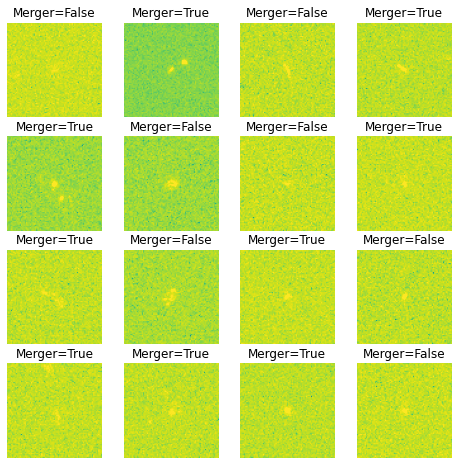

In [34]:
# select 16 random image indices:
example_ids = np.random.choice(hdu_noisy[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu_noisy[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8)) 

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='viridis', norm=norm)
    ax.set_title('Merger='+str(bool(hdu_noisy[1].data[example_ids[i]][0])))
    
    ax.axis('off')
    
plt.show()

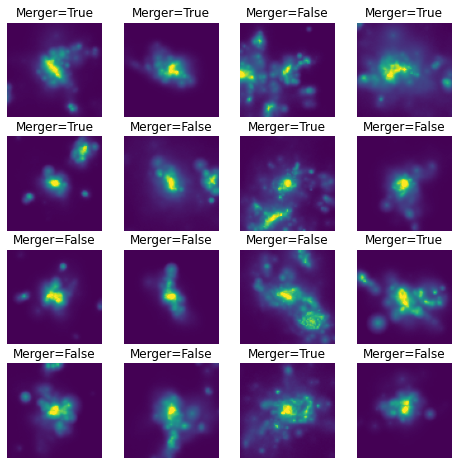

In [35]:
# select 16 random image indices:
example_ids = np.random.choice(hdu_pristine[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu_pristine[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8)) 

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='viridis', norm=norm)
    ax.set_title('Merger='+str(bool(hdu_pristine[1].data[example_ids[i]][0])))
    
    ax.axis('off')
    
plt.show()

## Section 3: preparing the data for modeling

#### Step 1: transforming data into a float32 object.

In [29]:
x_pr = np.asarray(x_pr).astype('float32')
y_pr = np.asarray(y_pr).astype('float32')

In [30]:
x_no = np.asarray(x_no).astype('float32')
y_no = np.asarray(y_no).astype('float32')

#### Step 2: Splitting data for modelling

For every neural network, data must be divided into 3 groups: **training data, validation data and testing data.** *Training* data is used for the learning process of the model. *Validation data* is used for validating the model during training. And finally, *testing* data is used only once, and for final testing. In this project, I am dividing the data into `70 % : 20 % : 10 %`. 70 % training, 20 % validation and 10 % testing. The same goes for labels. 

In [31]:
x_train_pr, x_rem_pr, y_train_pr, y_rem_pr = train_test_split(x_pr,y_pr, train_size=0.7, random_state=42, shuffle=True) # cutting off training data and the rest goes into the next stage

x_valid_pr, x_test_pr, y_valid_pr, y_test_pr = train_test_split(x_rem_pr,y_rem_pr, test_size=0.34, random_state=42, shuffle=True) # dividing the validation and testing sets

In [32]:
x_train_no, x_rem_no, y_train_no, y_rem_no = train_test_split(x_no,y_no, train_size=0.7, random_state=42, shuffle=True) # cutting off training data and the rest goes into the next stage

x_valid_no, x_test_no, y_valid_no, y_test_no = train_test_split(x_rem_no,y_rem_no, test_size=0.34, random_state=42, shuffle=True) # dividing the validation and testing sets

#### Step 3: transforming the data into `Tensor` objects

Because I am working with the `pytorch` library, `Tensor` objects are a must. Tensors are packages of numerical data or arrays. An `array` is a collection of data which is of the same type, where every entry has its own index. Our pictures are 3-dimensional Tensors because they have multiple layers. 

In [36]:
x_train_pr, y_train_pr, x_valid_pr, y_valid_pr, x_test_pr, y_test_pr = map(torch.tensor, (x_train_pr, y_train_pr, x_valid_pr, y_valid_pr, x_test_pr, y_test_pr))

In [37]:
x_train_no, y_train_no, x_valid_no, y_valid_no, x_test_no, y_test_no = map(torch.tensor, (x_train_no, y_train_no, x_valid_no, y_valid_no, x_test_no, y_test_no))

#### Step 4: organizing the data into batches

The last step is organizing this data into batches. Batches help in the learning process and stop the computer from crashing during training, validation and testing.

In [38]:
bs = 64
train_ds_pr = TensorDataset(x_train_pr, y_train_pr)
train_dl_pr = DataLoader(train_ds_pr, batch_size=bs, shuffle=True)

valid_ds_pr = TensorDataset(x_valid_pr, y_valid_pr)
valid_dl_pr = DataLoader(valid_ds_pr, batch_size=bs)

test_ds_pr = TensorDataset(x_test_pr, y_test_pr)
test_dl_pr = DataLoader(test_ds_pr, batch_size=bs)

In [39]:
bs = 64
train_ds_no = TensorDataset(x_train_no, y_train_no)
train_dl_no = DataLoader(train_ds_no, batch_size=bs, shuffle=True)

valid_ds_no = TensorDataset(x_valid_no, y_valid_no)
valid_dl_no = DataLoader(valid_ds_no, batch_size=bs)

test_ds_no = TensorDataset(x_test_no, y_test_no)
test_dl_no = DataLoader(test_ds_no, batch_size=bs)

And with the last step complete, our simulated data is completely ready for modeling. In notebook 03, I discuss the process for creating the real images dataset.

In [40]:
train_dl_pr, valid_dl_pr, test_dl_pr = pristine_data(64)
train_dl_no, valid_dl_no, test_dl_no = noisy_data(64)

ModuleNotFoundError: No module named 'sim_data'